In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from pathlib import Path
from logging import Logger
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
from operator import itemgetter, attrgetter
import itertools
import collections

import numpy as np

from utils.setup import easy_logger, get_device
from const.const_values import PROJECT_DIR

os.chdir(PROJECT_DIR)
logger: Logger = easy_logger(f'{PROJECT_DIR}/log/jupyter_run.log')
device = get_device(device_name='cpu', logger=logger)
print(PROJECT_DIR)

/Users/ryoyakaneda/Documents/学校/M1Study/knowledge_graph


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
wn18rr_train_file_path = f"{PROJECT_DIR}/data/external/KGdata/WN18RR/text/train.txt"
wn18rr_valid_file_path = f"{PROJECT_DIR}/data/external/KGdata/WN18RR/text/valid.txt"
wn18rr_test_file_path = f"{PROJECT_DIR}/data/external/KGdata/WN18RR/text/test.txt"
HEAD, RELATION, TAIL = 'head', 'relation', 'tail'
MODE = 'mode'
HYPERNYM = '_hypernym'

In [3]:
def get_hypernym_list(key, list_, *, hypernym_dict):
    list_ = list_ + [key]
    list_list = []
    for child_key in hypernym_dict[key]:
        if child_key in set(list_):
            list_list.append(list_)
        else:
            list_list.extend(get_hypernym_list(child_key, list_, hypernym_dict=hypernym_dict))
    if len(list_list)==0:
        list_list = [list_]
    return list_list

def get_entity_relation(df):
    return pd.concat([df[HEAD], df[TAIL]]).sort_values(), df[RELATION].sort_values()

def get_hypernym_df(df):
    return df[df[RELATION]==HYPERNYM]

def get_hypernym_dict(df, entities):
    hypernym_df = get_hypernym_df(df)
    hypernym_dict = {key: [] for key in entities}
    for index, row in hypernym_df.iterrows():
        hypernym_dict[row[HEAD]].append(row[TAIL])
    return hypernym_dict

def get_entity2triples(df):
    entities, _ = get_entity_relation(df)
    entity2triples = {key: [] for key in entities}
    for index, row in df.iterrows():
        triple = (row[HEAD], row[RELATION], row[TAIL], (index, row[MODE]))
        entity2triples[row[HEAD]].append(triple)
    return entity2triples

def get_to_top_list_list(df):
    hypernym_df = get_hypernym_df(df)
    hypernym_bottom_entity_set = set(hypernym_df[HEAD]) - set(hypernym_df[TAIL])
    hypernym_df = get_hypernym_df(df)
    entities, _ = get_entity_relation(df)
    hypernym_dict = get_hypernym_dict(hypernym_df, entities)
    to_top_list_list = []
    for e in hypernym_bottom_entity_set:
        to_top_list = get_hypernym_list(e, [], hypernym_dict=hypernym_dict)
        to_top_list_list.extend(to_top_list)
    return to_top_list_list

def get_to_top_triples_list(df, to_top_list_list):
    entity2triples = get_entity2triples(df)
    to_top_triples_list = []
    for to_top_list in to_top_list_list:
        to_top_triples = []
        for e in to_top_list:
            to_top_triples.extend(entity2triples[e])
        to_top_triples_list.append(to_top_triples)
    return to_top_triples_list

def get_to_top_triples_list_limit_(to_top_triples_list, limit):
    to_top_triples_list_limit_ = []
    for list_ in to_top_triples_list:
        for i in range(0, len(list_), limit):
            to_top_triples_list_limit_.append(list_[i: i+limit])
    return to_top_triples_list_limit_

In [4]:
def func01(df, *, to_top_list_list=None):
    df = df.sort_values([HEAD, RELATION, TAIL]).reset_index()

    if to_top_list_list is None: to_top_list_list = get_to_top_list_list(df)
    to_top_triples_list = get_to_top_triples_list(df, to_top_list_list)

    to_top_triples_list_limit32 = get_to_top_triples_list_limit_(to_top_triples_list, 32)
    return to_top_list_list, to_top_triples_list, to_top_triples_list_limit32

In [5]:
def main():
    train_df = pd.read_table(wn18rr_train_file_path, header=None, names=(HEAD, RELATION, TAIL)).assign(**{MODE: 1})
    valid_df = pd.read_table(wn18rr_valid_file_path, header=None, names=(HEAD, RELATION, TAIL)).assign(**{MODE: 2})
    test_df = pd.read_table(wn18rr_test_file_path, header=None, names=(HEAD, RELATION, TAIL)).assign(**{MODE: 3})
    train_to_top_list_list, train_to_top_triples_list, train_to_top_triples_list_limit32 = func01(train_df)
    valid_to_top_list_list, valid_to_top_triples_list, valid_to_top_triples_list_limit32 = func01(
        pd.concat([train_df, valid_df]), to_top_list_list=train_to_top_list_list)
    return (
        train_to_top_list_list, train_to_top_triples_list, train_to_top_triples_list_limit32,
        valid_to_top_list_list, valid_to_top_triples_list, valid_to_top_triples_list_limit32
    )

In [6]:
(train_to_top_list_list, train_to_top_triples_list, train_to_top_triples_list_limit32,
 valid_to_top_list_list, valid_to_top_triples_list, valid_to_top_triples_list_limit32
) = main()

(array([2570., 2344., 3195., 4761., 6458., 4573., 2724., 1809., 1022.,
         969.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

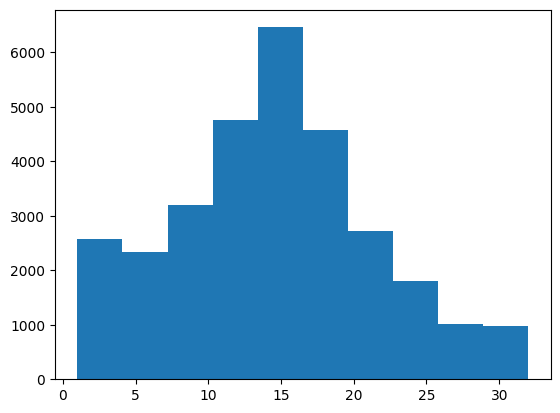

In [7]:
plt.hist([len(list_) for list_ in train_to_top_triples_list_limit32])

(array([2361., 2381., 3152., 4520., 6239., 4796., 2866., 1993., 1129.,
        1090.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

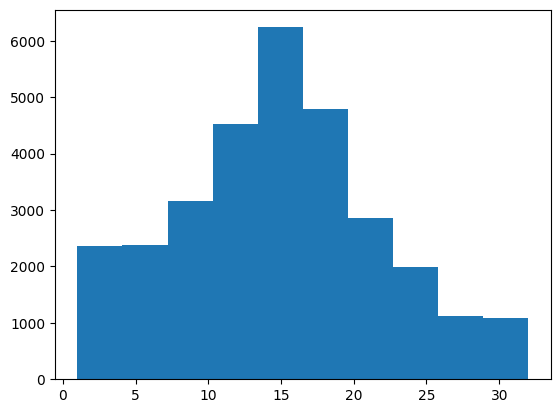

In [8]:
plt.hist([len(list_) for list_ in valid_to_top_triples_list_limit32])

In [10]:
len(train_to_top_triples_list), len(valid_to_top_triples_list)

(29961, 29961)

In [12]:
valid_to_top_triples_list[:10]

[[('spectacle.n.03', '_hypernym', 'blunder.n.01', 1),
  ('blunder.n.01', '_derivationally_related_form', 'bungle.v.02', 1),
  ('blunder.n.01', '_derivationally_related_form', 'drop_the_ball.v.01', 1),
  ('blunder.n.01', '_hypernym', 'mistake.n.01', 1),
  ('mistake.n.01', '_derivationally_related_form', 'blame.v.01', 1),
  ('mistake.n.01', '_derivationally_related_form', 'err.v.01', 1),
  ('mistake.n.01', '_hypernym', 'nonaccomplishment.n.01', 1),
  ('nonaccomplishment.n.01', '_hypernym', 'act.n.02', 1),
  ('act.n.02', '_derivationally_related_form', 'act.v.01', 1),
  ('act.n.02', '_derivationally_related_form', 'motivate.v.01', 1),
  ('act.n.02', '_derivationally_related_form', 'trip.v.04', 1),
  ('act.n.02', '_hypernym', 'event.n.01', 1),
  ('event.n.01', '_hypernym', 'psychological_feature.n.01', 1),
  ('psychological_feature.n.01', '_hypernym', 'abstraction.n.06', 1),
  ('abstraction.n.06', '_derivationally_related_form', 'abstract.v.01', 1),
  ('abstraction.n.06', '_hypernym', 'ent